In [1]:
import json

with open("/home/huy/Project/educAItion/data.json", "r", encoding="utf-8") as file:
    data = json.load(file)

question_count = sum(len(topic["questions"]) for chapter in data["data"] for topic in chapter["topics"])

print("Total number of questions:", question_count)


Total number of questions: 162


In [2]:


PROMPT_text = """
Hãy giải bài toán theo từng bước, và giải thích bước làm.
Hãy trả về kết quả dạng LaTeX cho các công thức toán học (để trong $...$ cho các biểu thức, số), bảng biến thiên, đồ thị,... nếu có.

=========
Đây là bài toán:
{problem}

=========

LƯU Ý: 
- Hãy giải bằng cách ngắn gọn, hiệu quả nhất.
- Hãy trình bày khoa học và dùng các ký hiệu toán học nếu có thể để thay cho chữ 
- Ví dụ dùng kí hiệu toán là dấu "hoặc", "và" khi giải phương trình, bất phương trình; Hay vẽ bảng biến thiên khảo sát hàm số hay xét dấu,.... 
- Nên xuống dòng khi cần thiết, tránh một dòng quá dài.
-Trả về dưới dạng tag : <solution>solution<solution> <answer>answer<answer> trong đó solution là cách giải, anser là kết quả cuối cùng theo yêu cầu bài toán.
-Trả về kết quả dưới dạng Latex
"""

In [1]:

from dotenv import load_dotenv
import os
from google import genai

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
gemini_api_key = os.getenv("GEMINI_API_KEY")

from langchain_openai import OpenAI, ChatOpenAI
from typing import List, Dict, Any, Optional, Tuple
from abc import ABC, abstractmethod
from langchain.schema.messages import HumanMessage, SystemMessage


class LLM(ABC):
    @abstractmethod
    def generate(self, prompt: str) -> str:
        pass
    
    @abstractmethod
    def stream_generate(self, prompt: str):
        pass

class LangchainOpenAI(LLM):
    def __init__(self, model_name="gpt-4o"):
        self.chat_model = ChatOpenAI(
            model=model_name,
            temperature=0
        )
        self.stream_model = ChatOpenAI(
            model=model_name,
            temperature=0,
            streaming=True
        )
    
    def generate(self, prompt: str) -> str:
        messages = [HumanMessage(content=prompt)]
        return self.chat_model.invoke(messages).content
    
    def stream_generate(self, prompt: str):
        messages = [HumanMessage(content=prompt)]
        for chunk in self.stream_model.stream(messages):
            if chunk.content:
                yield chunk.content

class GeminiAI(LLM):
    def __init__(self):
        self.client = genai.Client(api_key=gemini_api_key)
    
    def generate(self, prompt: str) -> str:
        response = self.client.models.generate_content(model="gemini-2.0-flash",contents=[prompt])
        return response.text
    

    def stream_generate(self, prompt: str):
        response = self.client.models.generate_content_stream(model="gemini-2.0-flash",contents=[prompt])
        
        for chunk in response:
            if chunk.text:
                yield chunk.text

In [2]:

import re
import pandas as pd

from IPython.display import display, Latex
import json

from tqdm import tqdm

model = LangchainOpenAI()
def get_answer(problem):
    response =  model.generate(PROMPT_text.format(problem=problem))
    if response is None:
            return {"solution": "AI failed to generate a solution", "answer": "AI failed to generate an answer"}
    solution_match = re.search(r"<solution>(.*?)</solution>", response, re.DOTALL)
    answer_match = re.search(r"<answer>(.*?)</answer>", response, re.DOTALL)
    
    # Extracted values or default
    solution = solution_match.group(1) if solution_match else "No solution found"
    answer = answer_match.group(1) if answer_match else "No answer found"
    
    return {"solution": solution, "answer": answer}

In [6]:
rows = []
questions_list = [q for chapter in data["data"] for topic in chapter["topics"] for q in topic["questions"]]

for q in tqdm(questions_list, desc="Processing Questions"):
    ai_response = get_answer(q["question"])
    display(Latex(ai_response["solution"]))
    rows.append([
        q["question"], 
        q["solution"], 
        q["answer"], 
        ai_response["solution"], 
        ai_response["answer"]
    ])

# Create DataFrame
df = pd.DataFrame(rows, columns=["Question", "Solution", "Answer", "AI Solution", "AI Answer"])


# Display DataFrame
display(df)

Processing Questions:   0%|          | 0/162 [00:00<?, ?it/s]

<IPython.core.display.Latex object>

Processing Questions:   1%|          | 1/162 [00:07<19:45,  7.36s/it]

<IPython.core.display.Latex object>

Processing Questions:   1%|          | 2/162 [00:14<20:01,  7.51s/it]

<IPython.core.display.Latex object>

Processing Questions:   2%|▏         | 3/162 [00:28<26:58, 10.18s/it]

<IPython.core.display.Latex object>

Processing Questions:   2%|▏         | 4/162 [00:37<25:51,  9.82s/it]

<IPython.core.display.Latex object>

Processing Questions:   3%|▎         | 5/162 [00:47<25:47,  9.86s/it]

<IPython.core.display.Latex object>

Processing Questions:   4%|▎         | 6/162 [00:59<27:13, 10.47s/it]

<IPython.core.display.Latex object>

Processing Questions:   4%|▍         | 7/162 [01:10<27:44, 10.74s/it]

<IPython.core.display.Latex object>

Processing Questions:   5%|▍         | 8/162 [01:22<28:34, 11.13s/it]

<IPython.core.display.Latex object>

Processing Questions:   6%|▌         | 9/162 [01:31<26:33, 10.42s/it]

<IPython.core.display.Latex object>

Processing Questions:   6%|▌         | 10/162 [01:41<26:01, 10.27s/it]

<IPython.core.display.Latex object>

Processing Questions:   7%|▋         | 11/162 [01:56<29:39, 11.78s/it]

<IPython.core.display.Latex object>

Processing Questions:   7%|▋         | 12/162 [02:14<34:02, 13.61s/it]

<IPython.core.display.Latex object>

Processing Questions:   8%|▊         | 13/162 [02:21<29:16, 11.79s/it]

<IPython.core.display.Latex object>

Processing Questions:   9%|▊         | 14/162 [02:43<36:10, 14.66s/it]

<IPython.core.display.Latex object>

Processing Questions:   9%|▉         | 15/162 [02:59<37:16, 15.21s/it]

<IPython.core.display.Latex object>

Processing Questions:  10%|▉         | 16/162 [03:13<35:55, 14.76s/it]

<IPython.core.display.Latex object>

Processing Questions:  10%|█         | 17/162 [03:36<41:49, 17.31s/it]

<IPython.core.display.Latex object>

Processing Questions:  11%|█         | 18/162 [03:56<43:21, 18.07s/it]

<IPython.core.display.Latex object>

Processing Questions:  12%|█▏        | 19/162 [04:06<37:33, 15.76s/it]

<IPython.core.display.Latex object>

Processing Questions:  12%|█▏        | 20/162 [04:20<35:38, 15.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  13%|█▎        | 21/162 [04:35<35:53, 15.27s/it]

<IPython.core.display.Latex object>

Processing Questions:  14%|█▎        | 22/162 [04:46<32:32, 13.94s/it]

<IPython.core.display.Latex object>

Processing Questions:  14%|█▍        | 23/162 [04:56<29:18, 12.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  15%|█▍        | 24/162 [05:10<30:11, 13.12s/it]

<IPython.core.display.Latex object>

Processing Questions:  15%|█▌        | 25/162 [05:31<35:00, 15.33s/it]

<IPython.core.display.Latex object>

Processing Questions:  16%|█▌        | 26/162 [05:40<30:35, 13.50s/it]

<IPython.core.display.Latex object>

Processing Questions:  17%|█▋        | 27/162 [05:50<27:53, 12.40s/it]

<IPython.core.display.Latex object>

Processing Questions:  17%|█▋        | 28/162 [06:10<33:09, 14.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  18%|█▊        | 29/162 [06:21<30:03, 13.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▊        | 30/162 [06:39<32:39, 14.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▉        | 31/162 [06:54<32:52, 15.05s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|█▉        | 32/162 [07:14<35:44, 16.50s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|██        | 33/162 [07:30<34:51, 16.21s/it]

<IPython.core.display.Latex object>

Processing Questions:  21%|██        | 34/162 [07:44<33:10, 15.55s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 35/162 [07:58<32:25, 15.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 36/162 [08:13<31:52, 15.18s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 37/162 [08:19<25:52, 12.42s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 38/162 [08:28<23:16, 11.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  24%|██▍       | 39/162 [08:38<22:33, 11.01s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▍       | 40/162 [08:50<22:44, 11.19s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▌       | 41/162 [09:08<26:52, 13.33s/it]

<IPython.core.display.Latex object>

Processing Questions:  26%|██▌       | 42/162 [09:28<30:22, 15.19s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 43/162 [09:39<27:48, 14.02s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 44/162 [10:00<31:30, 16.02s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 45/162 [10:27<37:48, 19.39s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 46/162 [10:58<44:14, 22.88s/it]

<IPython.core.display.Latex object>

Processing Questions:  29%|██▉       | 47/162 [11:18<42:24, 22.13s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|██▉       | 48/162 [11:41<42:05, 22.16s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|███       | 49/162 [12:11<46:18, 24.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███       | 50/162 [12:29<42:18, 22.66s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███▏      | 51/162 [13:03<48:29, 26.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  32%|███▏      | 52/162 [13:27<46:25, 25.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 53/162 [13:51<45:32, 25.07s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 54/162 [14:11<42:05, 23.39s/it]

<IPython.core.display.Latex object>

Processing Questions:  34%|███▍      | 55/162 [14:27<37:54, 21.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▍      | 56/162 [14:41<33:52, 19.18s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▌      | 57/162 [14:54<30:12, 17.27s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▌      | 58/162 [15:09<28:36, 16.50s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▋      | 59/162 [15:24<27:29, 16.01s/it]

<IPython.core.display.Latex object>

Processing Questions:  37%|███▋      | 60/162 [15:39<26:59, 15.88s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 61/162 [15:47<22:37, 13.44s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 62/162 [16:02<23:07, 13.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  39%|███▉      | 63/162 [16:14<21:54, 13.27s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|███▉      | 64/162 [16:35<25:39, 15.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|████      | 65/162 [16:50<25:11, 15.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████      | 66/162 [17:03<23:31, 14.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████▏     | 67/162 [17:16<22:11, 14.02s/it]

<IPython.core.display.Latex object>

Processing Questions:  42%|████▏     | 68/162 [17:22<18:24, 11.75s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 69/162 [17:42<22:10, 14.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 70/162 [18:03<24:40, 16.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 71/162 [18:20<25:03, 16.52s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 72/162 [18:40<26:33, 17.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  45%|████▌     | 73/162 [18:49<22:04, 14.88s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▌     | 74/162 [19:08<23:50, 16.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▋     | 75/162 [19:28<24:55, 17.18s/it]

<IPython.core.display.Latex object>

Processing Questions:  47%|████▋     | 76/162 [19:55<29:01, 20.24s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 77/162 [20:18<29:53, 21.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 78/162 [20:41<30:13, 21.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 79/162 [21:04<30:20, 21.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 80/162 [21:11<24:10, 17.69s/it]

<IPython.core.display.Latex object>

Processing Questions:  50%|█████     | 81/162 [21:27<22:53, 16.96s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 82/162 [21:41<21:38, 16.23s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 83/162 [21:48<17:30, 13.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 84/162 [22:00<17:05, 13.15s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 85/162 [22:13<16:39, 12.98s/it]

<IPython.core.display.Latex object>

Processing Questions:  53%|█████▎    | 86/162 [22:34<19:20, 15.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▎    | 87/162 [23:00<23:16, 18.62s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▍    | 88/162 [23:21<23:43, 19.23s/it]

<IPython.core.display.Latex object>

Processing Questions:  55%|█████▍    | 89/162 [23:33<20:53, 17.18s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 90/162 [23:44<18:20, 15.28s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 91/162 [23:56<16:54, 14.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 92/162 [24:18<19:31, 16.73s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 93/162 [24:41<21:12, 18.44s/it]

<IPython.core.display.Latex object>

Processing Questions:  58%|█████▊    | 94/162 [24:58<20:34, 18.16s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▊    | 95/162 [25:26<23:23, 20.95s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▉    | 96/162 [25:43<21:48, 19.82s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|█████▉    | 97/162 [25:56<19:09, 17.69s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|██████    | 98/162 [26:09<17:29, 16.40s/it]

<IPython.core.display.Latex object>

Processing Questions:  61%|██████    | 99/162 [26:19<15:12, 14.48s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 100/162 [26:44<18:10, 17.58s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 101/162 [27:04<18:35, 18.28s/it]

<IPython.core.display.Latex object>

Processing Questions:  63%|██████▎   | 102/162 [27:14<15:56, 15.95s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▎   | 103/162 [27:37<17:39, 17.95s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▍   | 104/162 [28:00<18:44, 19.39s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▍   | 105/162 [28:20<18:36, 19.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▌   | 106/162 [28:33<16:24, 17.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  66%|██████▌   | 107/162 [28:56<17:38, 19.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 108/162 [29:15<17:19, 19.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 109/162 [29:34<17:03, 19.31s/it]

<IPython.core.display.Latex object>

Processing Questions:  68%|██████▊   | 110/162 [30:01<18:31, 21.38s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▊   | 111/162 [30:13<15:54, 18.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▉   | 112/162 [30:26<14:08, 16.97s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|██████▉   | 113/162 [30:43<13:49, 16.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|███████   | 114/162 [30:52<11:43, 14.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  71%|███████   | 115/162 [31:03<10:36, 13.55s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 116/162 [31:17<10:26, 13.63s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 117/162 [31:31<10:19, 13.76s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 118/162 [31:42<09:23, 12.80s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 119/162 [31:51<08:20, 11.63s/it]

<IPython.core.display.Latex object>

Processing Questions:  74%|███████▍  | 120/162 [32:04<08:37, 12.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▍  | 121/162 [32:18<08:37, 12.62s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▌  | 122/162 [32:33<08:50, 13.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  76%|███████▌  | 123/162 [32:51<09:35, 14.74s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 124/162 [33:22<12:31, 19.78s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 125/162 [33:42<12:07, 19.67s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 126/162 [33:59<11:18, 18.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 127/162 [34:17<10:55, 18.73s/it]

<IPython.core.display.Latex object>

Processing Questions:  79%|███████▉  | 128/162 [34:35<10:31, 18.58s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|███████▉  | 129/162 [34:54<10:16, 18.69s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|████████  | 130/162 [35:09<09:23, 17.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████  | 131/162 [35:20<07:58, 15.45s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████▏ | 132/162 [35:26<06:19, 12.66s/it]

<IPython.core.display.Latex object>

Processing Questions:  82%|████████▏ | 133/162 [35:33<05:20, 11.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 134/162 [35:47<05:34, 11.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 135/162 [36:05<06:13, 13.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  84%|████████▍ | 136/162 [36:29<07:15, 16.74s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▍ | 137/162 [36:44<06:43, 16.16s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▌ | 138/162 [36:51<05:21, 13.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▌ | 139/162 [37:07<05:27, 14.24s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▋ | 140/162 [37:20<05:03, 13.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  87%|████████▋ | 141/162 [37:50<06:33, 18.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 142/162 [38:09<06:18, 18.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 143/162 [38:27<05:51, 18.49s/it]

<IPython.core.display.Latex object>

Processing Questions:  89%|████████▉ | 144/162 [38:51<06:04, 20.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|████████▉ | 145/162 [39:12<05:46, 20.36s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|█████████ | 146/162 [39:32<05:23, 20.24s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████ | 147/162 [39:50<04:52, 19.52s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████▏| 148/162 [40:10<04:38, 19.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  92%|█████████▏| 149/162 [40:29<04:12, 19.45s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 150/162 [40:48<03:52, 19.37s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 151/162 [41:12<03:47, 20.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 152/162 [41:35<03:35, 21.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 153/162 [41:41<02:32, 16.90s/it]

<IPython.core.display.Latex object>

Processing Questions:  95%|█████████▌| 154/162 [41:52<02:00, 15.05s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▌| 155/162 [42:08<01:47, 15.33s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▋| 156/162 [42:30<01:43, 17.19s/it]

<IPython.core.display.Latex object>

Processing Questions:  97%|█████████▋| 157/162 [42:39<01:14, 14.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 158/162 [42:57<01:03, 15.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 159/162 [43:12<00:47, 15.69s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 160/162 [43:29<00:31, 15.97s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 161/162 [43:41<00:14, 14.84s/it]

<IPython.core.display.Latex object>

Processing Questions: 100%|██████████| 162/162 [43:58<00:00, 16.28s/it]


,Question,Solution,Answer,AI Solution,AI Answer
0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,\n\nĐể tìm phần thực của số phức $z = z_1 + z_...,\n\nPhần thực của số phức $z$ là $10$.\n\n
1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\n\nĐể giải bài toán này, ta cần tính giá trị ...",\n\nSố phức $z$ là:\n\n$$ z = 2 + 8i $$\n\n
2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3","\n\nĐể giải bài toán này, ta cần tìm các giá t...","\n$x = -5, \quad y = -\frac{5}{3}$\n"
3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),\n\nĐể xác định số nào trong các số phức đã ch...,\n\nBiểu thức B: $(8 + 2i) + (-8 + 2i)$ là số ...
4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,"\n\nĐể giải bài toán này, ta cần biết rằng $i$...",\n2\n
...,...,...,...,...,...
157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\n\nĐể tính thể tích của khối tròn xoay tạo th...,\n\n$V = \frac{16\pi}{15}$\n\n
158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\n\nĐể tính thể tích của khối tròn xoay được t...,\nThể tích của khối tròn xoay là $V = \frac{46...
159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,\n\nĐể tính thể tích của khối tròn xoay tạo th...,\nThể tích của khối tròn xoay là $\frac{\pi}{6...
160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\n\nĐể tìm thể tích của khối tròn xoay khi qua...,\n\nThể tích của khối tròn xoay là:\n\n\[\nV =...


In [8]:
df.to_csv("4o_test_results.csv")

In [10]:
import pandas as pd
df = pd.read_csv("4o_test_results.csv").drop(["Category", "Explanation"], axis=1)
model = GeminiAI()

In [14]:
import time
import re
import pandas as pd
from tqdm import tqdm

# Function to classify AI answer correctness

def check_answer(correct_answer, ai_answer):
    prompt = (f'''Compare the correct answer '{correct_answer}' with the AI-generated answer '{ai_answer}'. 
              Categorize the result into one of the following:
              1. 'Both Correct' - AI answer is meaningfully correct.
              2. 'Both Incorrect' - AI uses incorrect reasoning, both is incorrect.
              3. 'Correct Answer, Wrong Explanation' - The answer is correct, but the reasoning is flawed.
              4. 'Wrong Answer, Correct Explanation' - The answer is wrong, but the reasoning is valid.
              5. 'AI Not Generated' - AI did not produce an answer.
              
              Be lenient in formatting and minor differences as long as the meaning aligns. 
              Return only the category and a brief explanation.
              ''')

    global last_api_call_time
    elapsed_time = time.time() - last_api_call_time
    if elapsed_time < 4:
        time.sleep(4 - elapsed_time)  # Enforce rate limit

    response = model.generate(prompt)
    last_api_call_time = time.time()

    if response is None:
        return "AI Not Generated", "AI failed to generate a response"

    match = re.search(r"(Both Correct|Both Incorrect|Correct Answer, Wrong Explanation|Wrong Answer, Correct Explanation|AI Not Generated)", response)
    explanation_match = re.search(r"Explanation:\s*(.*)", response, re.DOTALL)
    
    category = match.group(1) if match else "Unknown"
    explanation = explanation_match.group(1).strip() if explanation_match else "No explanation provided"
    
    return category, explanation

# Initialize rate limit tracking
last_api_call_time = time.time()

# Ensure necessary columns exist
if "Category" not in df.columns:
    df["Category"] = None
if "Explanation" not in df.columns:
    df["Explanation"] = None

# Iterate through DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking AI Answers"):
    if pd.notna(row["Category"]):
        continue
    
    category, explanation = check_answer(row["Answer"], row["AI Answer"])
    df.at[index, "Category"] = category
    df.at[index, "Explanation"] = explanation

# Display updated DataFrame
display(df)


Checking AI Answers: 100%|██████████| 162/162 [14:56<00:00,  5.54s/it]


,Unnamed: 0.1,Unnamed: 0,Question,Solution,Answer,AI Solution,AI Answer,Category,Explanation
0,0,0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,\n\nĐể tìm phần thực của số phức $z = z_1 + z_...,\n\nPhần thực của số phức $z$ là $10$.\n\n,Both Correct,No explanation provided
1,1,1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\n\nĐể giải bài toán này, ta cần tính giá trị ...",\n\nSố phức $z$ là:\n\n$$ z = 2 + 8i $$\n\n,Both Correct,No explanation provided
2,2,2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3","\n\nĐể giải bài toán này, ta cần tìm các giá t...","\n$x = -5, \quad y = -\frac{5}{3}$\n",Both Correct,No explanation provided
3,3,3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),\n\nĐể xác định số nào trong các số phức đã ch...,\n\nBiểu thức B: $(8 + 2i) + (-8 + 2i)$ là số ...,Both Correct,No explanation provided
4,4,4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,"\n\nĐể giải bài toán này, ta cần biết rằng $i$...",\n2\n,Both Correct,No explanation provided
...,...,...,...,...,...,...,...,...,...
157,157,157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\n\nĐể tính thể tích của khối tròn xoay tạo th...,\n\n$V = \frac{16\pi}{15}$\n\n,Both Correct,No explanation provided
158,158,158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\n\nĐể tính thể tích của khối tròn xoay được t...,\nThể tích của khối tròn xoay là $V = \frac{46...,Both Correct,No explanation provided
159,159,159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,\n\nĐể tính thể tích của khối tròn xoay tạo th...,\nThể tích của khối tròn xoay là $\frac{\pi}{6...,Both Correct,No explanation provided
160,160,160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\n\nĐể tìm thể tích của khối tròn xoay khi qua...,\n\nThể tích của khối tròn xoay là:\n\n\[\nV =...,Both Correct,No explanation provided


Statistical Summary of AI Answer Classification:
Both Correct                         112
Wrong Answer, Correct Explanation     30
Correct Answer, Wrong Explanation      8
Both Incorrect                         8
AI Not Generated                       4
Name: Category, dtype: int64

Percentage Distribution:
Both Correct                         69.135802
Wrong Answer, Correct Explanation    18.518519
Correct Answer, Wrong Explanation     4.938272
Both Incorrect                        4.938272
AI Not Generated                      2.469136
Name: Category, dtype: float64


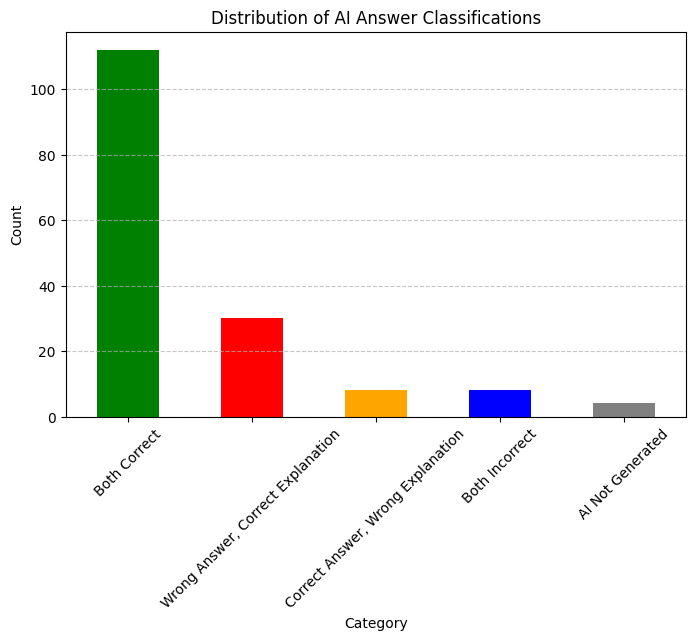

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each classification category
category_counts = df["Category"].value_counts()

# Compute percentages
category_percentages = (category_counts / len(df)) * 100

# Display statistical summary
print("Statistical Summary of AI Answer Classification:")
print(category_counts)
print("\nPercentage Distribution:")
print(category_percentages)

# Plot bar chart for better visualization
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["green", "red", "orange", "blue", "gray"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of AI Answer Classifications")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [16]:
df.to_csv("4o_test_results.csv")